## Building a deep neural network to detect vocalisation events of a critically endangered primate.

### Tasks:

*    You are provided with some audio dataset which has been manually annotated. The audio files are in the /Data/Audio folder. The annotations are in the /Data/Annotations folder
*    You will implement a 2D CNN bioacoustics classifier.
*    Do not implement transfer learning unless if you really want to.
* Submit your working Colab notebook to the tutor, Milanto by or before the deadline.
* **Deadline**: Sunday 21:00


I've added this line because the code which is automatically downloaded uses an old function definition for librosa's resample function. So to easily fix this I am downgrading the version.

You definitely want to make this a GPU instance and not just CPU!

In [1]:
# You might need to restart the runtime after running this code. You'll only
# have to do this once per runtime. Once you restart, you do not need to run this again
# [ 0 marks]
!pip install librosa==0.10.1
!pip install resampy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 22.3 MB/s eta 0:00:00


## Step 0: Download data and code

You will need to authenticate with your aims.ac.za Google account. It will pop up for you and you just need to sign in.

In [2]:
colab = True

In [3]:
# This snippet of code can take up to 5-6 minutes or so.
# Plase allow this to complete. [ 0 marks]
if colab:
    !pip install SoundFile
    from google.colab import drive
    from pydrive.auth import GoogleAuth
    from pydrive.drive import GoogleDrive
    from google.colab import auth
    from oauth2client.client import GoogleCredentials
    import zipfile

    # Google Authentication
    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    drive = GoogleDrive(gauth)

    # Download code files
    downloaded = drive.CreateFile({'id':"1js1fz4Bu98NIds4cErL7NdT1efxavixp"})
    downloaded.GetContentFile('Code.zip')

    # Extract files to temporary location in Google Drive
    with zipfile.ZipFile('Code.zip', 'r') as zip_file:
        zip_file.extractall()

    # Download data files
    downloaded = drive.CreateFile({'id':"15m8Y1REw0pbPHfnfSH7mAMXToXcuFM6l"})
    downloaded.GetContentFile('Data.zip')

    # Extract files to temporary location in Google Drive
    with zipfile.ZipFile('Data.zip', 'r') as zip_file:
        zip_file.extractall()

In [4]:
# Do not delete these imports [ 0 marks]
from Preprocessing import *
import librosa
import numpy as np
import random
import sklearn
from sklearn.model_selection import train_test_split

## Step 1: Pre-process the data

In [5]:
# Name for the presence and absence class based on how the data was annotated
# in sonicvisualiser [ 0 marks]
# -----------------------------
positive_class = ['1'] # which labels should be bundled together for the positive  class
negative_class = ['0'] # which labels should be bundled together for the negative  class


# Data hyper-parameters [ 0 marks]
# -----------------------------
lowpass_cutoff = 10000 # Cutt off for low pass filter
downsample_rate = 24000 # Frequency to downsample to
nyquist_rate = 12000 # Nyquist rate (half of sampling rate)
segment_duration = 2 # how long should a segment be


# Spectrogram hyper-parameters [ 0 marks]
# -----------------------------
n_fft = 1024 # Hann window length
hop_length = 256 # Sepctrogram hop size
n_mels = 128 # Spectrogram number of mells
f_min = 2000 # Spectrogram, minimum frequency for call
f_max = 9000 # Spectrogram, maximum frequency for call

# Don't change these [ 0 marks]
# -----------------------------
species_folder = '.' # Should contain /Audio and /Annotations, don't change this
file_type = 'svl' # don't change this
audio_extension = '.wav' #resampy

In [7]:
# This takes about 1-2 minutes [ 0 marks]
%%capture
pre_pro = Preprocessing(species_folder, lowpass_cutoff,
                downsample_rate, nyquist_rate,
                segment_duration,
                positive_class, negative_class,n_fft,
                hop_length, n_mels, f_min, f_max, file_type,
                audio_extension)

X, Y = pre_pro.create_dataset(False)

## Data shapes

In [8]:
X.shape

(5459, 48000)

In [9]:
%whos

Variable            Type               Data/Info
------------------------------------------------
AnnotationReader    type               <class 'AnnotationReader.AnnotationReader'>
GoogleAuth          type               <class 'pydrive.auth.GoogleAuth'>
GoogleCredentials   type               <class 'oauth2client.client.GoogleCredentials'>
GoogleDrive         type               <class 'pydrive.drive.GoogleDrive'>
Preprocessing       type               <class 'Preprocessing.Preprocessing'>
X                   ndarray            5459x48000: 262032000 elems, type `float64`, 2096256000 bytes (1999.1455078125 Mb)
Y                   ndarray            5459: 5459 elems, type `<U1`, 21836 bytes
audio_extension     str                .wav
auth                module             <module 'google.colab.aut<...>es/google/colab/auth.py'>
colab               bool               True
downloaded          GoogleDriveFile    GoogleDriveFile({'id': '1<...> True, 'canCopy': True}})
downsample_rate     int   

In [10]:
X_truncate = X
Y_truncate = Y
print(X_truncate.shape)
print(Y_truncate.shape)

(5459, 48000)
(5459,)


In [11]:
del X,Y

In [12]:
%whos

Variable            Type               Data/Info
------------------------------------------------
AnnotationReader    type               <class 'AnnotationReader.AnnotationReader'>
GoogleAuth          type               <class 'pydrive.auth.GoogleAuth'>
GoogleCredentials   type               <class 'oauth2client.client.GoogleCredentials'>
GoogleDrive         type               <class 'pydrive.drive.GoogleDrive'>
Preprocessing       type               <class 'Preprocessing.Preprocessing'>
X_truncate          ndarray            5459x48000: 262032000 elems, type `float64`, 2096256000 bytes (1999.1455078125 Mb)
Y_truncate          ndarray            5459: 5459 elems, type `<U1`, 21836 bytes
audio_extension     str                .wav
auth                module             <module 'google.colab.aut<...>es/google/colab/auth.py'>
colab               bool               True
downloaded          GoogleDriveFile    GoogleDriveFile({'id': '1<...> True, 'canCopy': True}})
downsample_rate     int   

In [13]:
print(X_truncate.shape)
print(Y_truncate.shape)


(5459, 48000)
(5459,)


In [14]:
test_audio = X_truncate[0]

In [15]:
test_audio.shape

(48000,)

In [14]:
# 1 create mel spectrogram you'll probably use librosa's built in melspectrogram
# function to do this. Use the hyper-parameters specified above.

# 2 View the mel spectrogram before doing anything else. Try and view a spectrogram
# that contains some type of sound.

# 3 decide on some normalisation (try avoid copy/pasting my code, and instead, try do
# this yourself.)

# 4 apply the normalisation to test_audio

# 5 View the normalised spectrogram

# 6 If it looks good, then you're done

### Task 1: preprocessing

The data in ``X`` and ``Y`` is not fully pre-processed. `X` has segments of audio which have been extracted from the audio files along with their label in `Y`.

*   Implement a function called ``audio_to_spectrogram(audio)`` which takes in one audio signal, and returns a mel-spectrogram.

*   This function should implement some type of normalisation.



In [16]:
def audio_to_spectrogram(audio):

  peak_amplitude = np.max(np.abs(audio))

  normalized_audio = audio * (-1/peak_amplitude)
  normalized_audio = np.clip(normalized_audio, -1, 1)

  S = librosa.feature.melspectrogram(y=normalized_audio, sr= len(normalized_audio), n_fft=n_fft, hop_length=hop_length, n_mels=n_mels, fmin = f_min, fmax = f_max)
  S_dB = librosa.power_to_db(S, ref=np.max)
  return S_dB

### Task 2

*   You need to add some code which visualises 3 gibbon presence events, and 3 gibbon absence events. You are free to plot any example in ``X`` and ``Y``. But the examples should be different.

Presence events

The spectogram for the audio X[34]


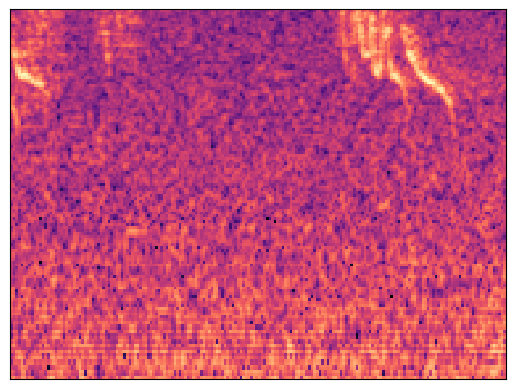

In [17]:
# random presence spectrogram
X_s = audio_to_spectrogram(X_truncate[34])
librosa.display.specshow(X_s)

# corresponding target
print('The spectogram for the audio X[34]')

In [18]:
X_s.shape

(128, 188)

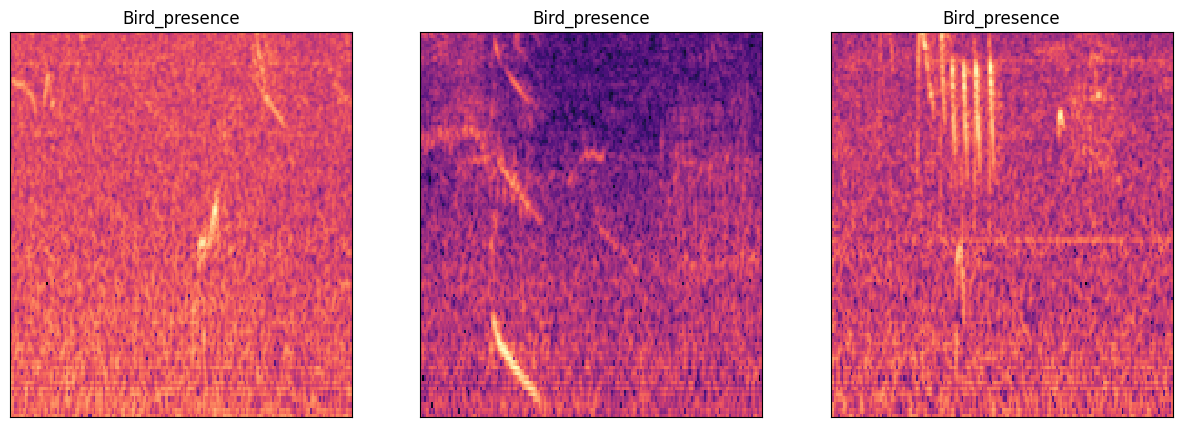

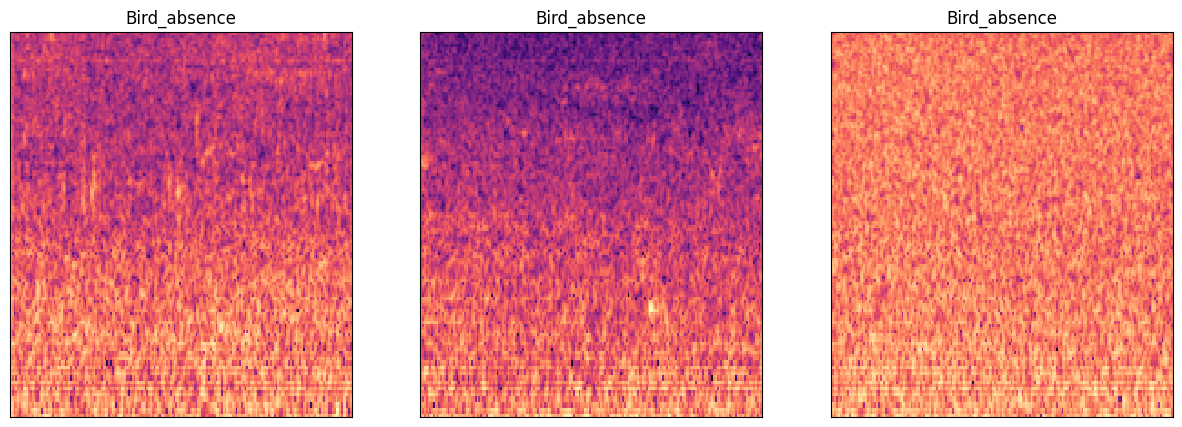

In [19]:
# Presence and absence indices
Bird_presence = [i for i, y in enumerate(Y_truncate) if y == '1']
Bird_absence = [i for i, y in enumerate(Y_truncate) if y == '0']

# Selecting the indices randomly
selected_presence = np.random.choice(Bird_presence, min(3, len(Bird_presence)), replace=False)
selected_absence = np.random.choice(Bird_absence, min(3, len(Bird_absence)), replace=False)

# Visualizing 3 gibbon presence events
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i, ax in zip(selected_presence, axs):
    spec = audio_to_spectrogram(X_truncate[i])
    librosa.display.specshow(spec, ax=ax)
    ax.set_title('Bird_presence')
plt.show()

# Visualizing 3 gibbon absence events
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i, ax in zip(selected_absence, axs):
    spec = audio_to_spectrogram(X_truncate[i])
    librosa.display.specshow(spec, ax=ax)
    ax.set_title('Bird_absence')
plt.show()


Absence events

Here is a function that will convert all of your audio segments into spectrograms, using the function you wrote above.

In [20]:
def convert_all_to_image(segments):

  spectrograms = []
  for segment in segments:
      spectrograms.append(audio_to_spectrogram(segment))

  return np.array(spectrograms)

Create all the spectrograms

You will probably get an output something like this: `(1524, 128, 76)`.

In [21]:
X_S = convert_all_to_image(X_truncate)

In [22]:
%whos

Variable               Type               Data/Info
---------------------------------------------------
AnnotationReader       type               <class 'AnnotationReader.AnnotationReader'>
Bird_absence           list               n=1139
Bird_presence          list               n=4320
GoogleAuth             type               <class 'pydrive.auth.GoogleAuth'>
GoogleCredentials      type               <class 'oauth2client.client.GoogleCredentials'>
GoogleDrive            type               <class 'pydrive.drive.GoogleDrive'>
Preprocessing          type               <class 'Preprocessing.Preprocessing'>
X_S                    ndarray            5459x128x188: 131365376 elems, type `float64`, 1050923008 bytes (1002.23828125 Mb)
X_s                    ndarray            128x188: 24064 elems, type `float64`, 192512 bytes (188.0 kb)
X_truncate             ndarray            5459x48000: 262032000 elems, type `float64`, 2096256000 bytes (1999.1455078125 Mb)
Y_truncate             ndarray    

In [24]:
X_S.shape

(5459, 128, 188)

Look how many precense and absence examples are in the training data.

In a normal situation you would have a lot more "absence" events, but this is an old code snippet and was deliberately created this way. So in practice this class balance would be a lot different. You'd have thousands of absence events, and very few presence events.

In [25]:
unique, counts = np.unique(Y_truncate, return_counts=True)
original_distribution = dict(zip(unique, counts))
print('Data distribution:',original_distribution)

Data distribution: {'0': 1139, '1': 4320}


### Task 3: given the values above, how many gibbon examples and no-gibbon examples would you like to have? You don't have to write anything down, just reflect on this.

### Task 4:

* Implement a function that will augment one spectrogram.
* The input will be a spectrogram, and it's target.
* The output should be the modified spectogram, and the target.

This function receives one spectrogram (2D matrix).

It also receives the true target value for that spectrogram

You must implement something to change the spectrogram in some way.

You do not need to get a noisy example or any external data, do mix up or anything complicated. Only manipulate this spectrogram stored in the variable `spectrogram` in some way so that this function acts like an augmetation function.

In [26]:
del X_truncate

In [27]:
%whos

Variable                Type               Data/Info
----------------------------------------------------
AnnotationReader        type               <class 'AnnotationReader.AnnotationReader'>
Bird_absence            list               n=1139
Bird_presence           list               n=4320
GoogleAuth              type               <class 'pydrive.auth.GoogleAuth'>
GoogleCredentials       type               <class 'oauth2client.client.GoogleCredentials'>
GoogleDrive             type               <class 'pydrive.drive.GoogleDrive'>
Preprocessing           type               <class 'Preprocessing.Preprocessing'>
X_S                     ndarray            5459x128x188: 131365376 elems, type `float64`, 1050923008 bytes (1002.23828125 Mb)
X_s                     ndarray            128x188: 24064 elems, type `float64`, 192512 bytes (188.0 kb)
Y_truncate              ndarray            5459: 5459 elems, type `<U1`, 21836 bytes
audio_extension         str                .wav
audio_to_spectr

In [28]:
import random
def augment_one_spectrogram(spectrogram, true_target):

  # TO DO
    shift = random.randint(0,len(spectrogram))

    # Perform the shift
    new_spectrogram = np.roll(spectrogram, shift,axis=1)

    return new_spectrogram, true_target



This function will randomly select one spectrogram which contains a gibbon call.

In [29]:
def randomly_select_presence(all_spectrograms, targets):

  # Find all the indices where there is a Bird example
  presence_indices = np.where(targets =='1')[0]

  # Randomly select index
  random_index = random.randint(0,len(presence_indices)-1)

  return all_spectrograms[presence_indices[random_index]]

This function will randomly select one spectrogram which does not contain a gibbon call.

In [30]:
def randomly_select_absence(all_spectrograms, targets):

  # Find all the indices where there is absence of bird example
  absence_indices = np.where(targets =='0')[0]

  # Randomly select index
  random_index = random.randint(0,len(absence_indices)-1)

  return all_spectrograms[absence_indices[random_index]]

This function will generate one new spectrogram with a Bird call in it.

In [31]:
def generate_new_presence_spectrograms(all_spectrograms, all_targets, quantity):

  new_spectrograms = []
  new_targets = []

  for i in range (0, quantity):
    presence_spectrogram = randomly_select_presence(all_spectrograms, all_targets)
    augmented_spectrogram, augmented_target = augment_one_spectrogram(presence_spectrogram,'1')

    new_spectrograms.append(augmented_spectrogram)
    new_targets.append(augmented_target)

  return np.asarray(new_spectrograms), np.asarray(new_targets)

This function will generate one new spectrogram without a Bird call in it.

In [32]:
def generate_new_absence_spectrograms(all_spectrograms, all_targets, quantity):

  new_spectrograms = []
  new_targets = []

  for i in range (0, quantity):
    absence_spectrogram = randomly_select_absence(all_spectrograms, all_targets)
    augmented_spectrogram, augmented_target = augment_one_spectrogram(absence_spectrogram,'0')

    new_spectrograms.append(augmented_spectrogram)
    new_targets.append(augmented_target)

  return np.asarray(new_spectrograms), np.asarray(new_targets)

### Task 5:

* Now generate actual gibbon calls, here you need to specify how many you want to create, extra. The value specified in the function is the amount of extra spectrograms that you want to create, which will contain gibbon calls.

In [33]:
new_presence, new_targets = generate_new_presence_spectrograms(X_S, Y_truncate, 1000)

Check the shapes of the newly created data

In [34]:
print(new_presence.shape)
print(new_targets.shape)

(1000, 128, 188)
(1000,)


### Task 6

Randomly select two of your newly created spectrograms, and view it.

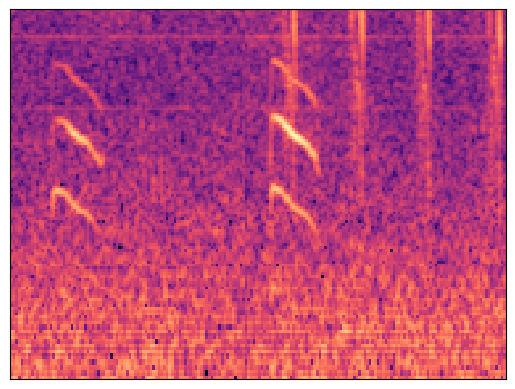

In [35]:
librosa.display.specshow(new_presence[10])

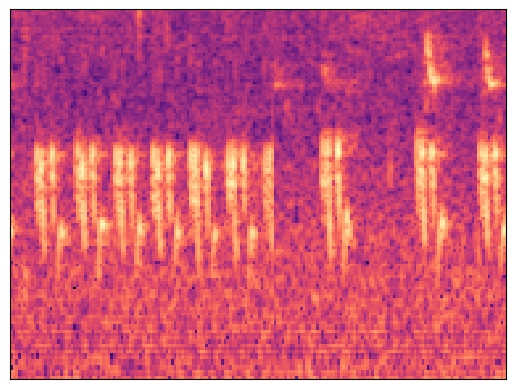

In [36]:
librosa.display.specshow(new_presence[20])

Now combine all of your existing spectrograms which contain gibbon calls, along with all of the newly created ones.

In [37]:
X_positive = np.concatenate([X_S[np.where(Y_truncate =='1')], new_presence])
X_positive = np.asarray(X_positive)
print(X_positive.shape)

Y_positive = np.concatenate([Y_truncate[np.where(Y_truncate =='1')], new_targets])
Y_positive = np.asarray(Y_positive)
print(Y_positive.shape)

(5320, 128, 188)
(5320,)


### Task 7

* Now generate actual absence spectrograms, here you need to specify how many you want to create, extra. The value specified in the function is the amount of extra spectrograms that you want to create, which will not contain gibbon calls.

In [38]:
%whos

Variable                             Type               Data/Info
-----------------------------------------------------------------
AnnotationReader                     type               <class 'AnnotationReader.AnnotationReader'>
Bird_absence                         list               n=1139
Bird_presence                        list               n=4320
GoogleAuth                           type               <class 'pydrive.auth.GoogleAuth'>
GoogleCredentials                    type               <class 'oauth2client.client.GoogleCredentials'>
GoogleDrive                          type               <class 'pydrive.drive.GoogleDrive'>
Preprocessing                        type               <class 'Preprocessing.Preprocessing'>
X_S                                  ndarray            5459x128x188: 131365376 elems, type `float64`, 1050923008 bytes (1002.23828125 Mb)
X_positive                           ndarray            5320x128x188: 128020480 elems, type `float64`, 1024163840 bytes (97

In [39]:
new_absence, new_targets = generate_new_absence_spectrograms(X_S, Y_truncate, 1000)

Check the shapes of the newly created data

In [40]:
print(new_absence.shape)
print(new_targets.shape)

(1000, 128, 188)
(1000,)


### Task 8

Randomly select two of your newly created spectrograms, and view it.

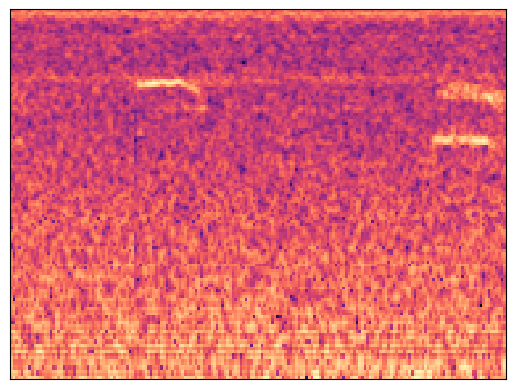

In [41]:
librosa.display.specshow(new_absence[10])

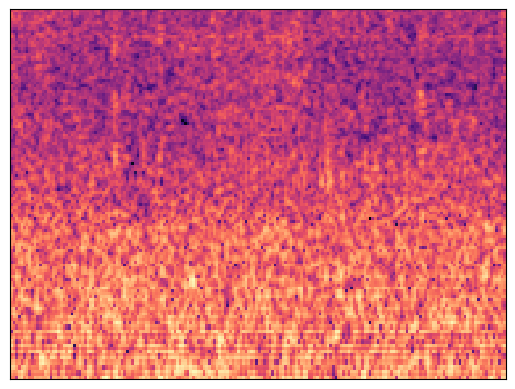

In [42]:
librosa.display.specshow(new_absence[1])

Now combine all of your existing spectrograms which do not contain gibbon calls, along with all of the newly created ones.

In [43]:
X_negatives = np.concatenate([X_S[np.where(Y_truncate =='0')], new_absence])
X_negatives = np.asarray(X_negatives)
print(X_negatives.shape)

Y_negatives = np.concatenate([Y_truncate[np.where(Y_truncate =='0')], new_targets])
Y_negatives = np.asarray(Y_negatives)
print(Y_negatives.shape)

(2139, 128, 188)
(2139,)


Combine all the positives features and negative features. Do the same for the targets

In [44]:
X_dataset = np.concatenate([X_positive, X_negatives])
Y_dataset = np.concatenate([Y_positive, Y_negatives])

Check the shapes of the completed dataset.

In [45]:
del X_S, Y_truncate

In [46]:
print(X_dataset.shape)
print(Y_dataset.shape)

(7459, 128, 188)
(7459,)


Reshape so that the data is in a format that is ready for Tensorflow.

In [47]:
X_dataset = np.expand_dims(X_dataset, axis=-1)

Check the shape again

In [48]:
print(X_dataset.shape)
print(Y_dataset.shape)

(7459, 128, 188, 1)
(7459,)


Some pre-processing to convert the categorical targets into one-hot encoded ones

In [49]:
from tensorflow.keras.utils import to_categorical
call_order = ['0','1']

# Converting categorical string labels ('gibbons' and 'no-gibbon) to 0s and 1s
for index, call_type in enumerate(call_order):
    Y_dataset = np.where(Y_dataset == call_type, index, Y_dataset)

Y_dataset = to_categorical(Y_dataset,
                             num_classes = 2)

Check shapes again

In [50]:
print(X_dataset.shape)
print(Y_dataset.shape)

(7459, 128, 188, 1)
(7459, 2)


Delete some RAM

In [51]:
%whos

Variable                             Type               Data/Info
-----------------------------------------------------------------
AnnotationReader                     type               <class 'AnnotationReader.AnnotationReader'>
Bird_absence                         list               n=1139
Bird_presence                        list               n=4320
GoogleAuth                           type               <class 'pydrive.auth.GoogleAuth'>
GoogleCredentials                    type               <class 'oauth2client.client.GoogleCredentials'>
GoogleDrive                          type               <class 'pydrive.drive.GoogleDrive'>
Preprocessing                        type               <class 'Preprocessing.Preprocessing'>
X_dataset                            ndarray            7459x128x188x1: 179493376 elems, type `float64`, 1435947008 bytes (1369.42578125 Mb)
X_negatives                          ndarray            2139x128x188: 51472896 elems, type `float64`, 411783168 bytes (39

In [52]:
del new_absence,new_presence

### Task 9: model training

* Implement your own network and training.
* You are free to do whatever you want and show/explain your reasoning. You are free to add text or anything else you want to share.

In [53]:
%whos

Variable                             Type               Data/Info
-----------------------------------------------------------------
AnnotationReader                     type               <class 'AnnotationReader.AnnotationReader'>
Bird_absence                         list               n=1139
Bird_presence                        list               n=4320
GoogleAuth                           type               <class 'pydrive.auth.GoogleAuth'>
GoogleCredentials                    type               <class 'oauth2client.client.GoogleCredentials'>
GoogleDrive                          type               <class 'pydrive.drive.GoogleDrive'>
Preprocessing                        type               <class 'Preprocessing.Preprocessing'>
X_dataset                            ndarray            7459x128x188x1: 179493376 elems, type `float64`, 1435947008 bytes (1369.42578125 Mb)
X_negatives                          ndarray            2139x128x188: 51472896 elems, type `float64`, 411783168 bytes (39

In [62]:
from tensorflow.keras.layers import Dense, Dropout, Flatten, MaxPooling2D, Conv2D ,AveragePooling2D
from tensorflow.keras.models import Sequential
from keras.callbacks import EarlyStopping
# TO DO
INPUT_SHAPE =(128, 188, 1)

# TO DO ...
model = Sequential()
model.add(Conv2D(32, kernel_size=3, activation='relu', input_shape=INPUT_SHAPE))
model.add(MaxPooling2D(pool_size=3))
model.add(Conv2D(16, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=3))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(2, activation='softmax'))
model.summary()

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 126, 186, 32)      320       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 42, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 40, 60, 16)        4624      
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 13, 20, 16)        0         
 g2D)                                                            
                                                                 
 flatten_4 (Flatten)         (None, 4160)              0         
                                                                 
 dense_12 (Dense)            (None, 128)              

Train the model

In [ ]:
# TO DO
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_dataset, Y_dataset ,epochs=10, validation_split=0.2,callbacks=[early_stop])

## Model Testing

*   Apply your model to each the test files ``(/Test_files/)``. There are 10 test files named ``check1.wav``, ..., ``check10.wav``. Please predict on all of the test files separately.

*   You should download the test data, open in SonicVisualiser, and check which files have calls and which don't to determine how good your model is doing. You don't have to demonstrate anything for this point. This is purely for your own checks.

Below I have provided some pre-processing code. The pre-processing of the training data used all of these functions, below, but they were hidden from you. They are actually in the Preprocessing.py file provided. You don't have to worry about anything here.

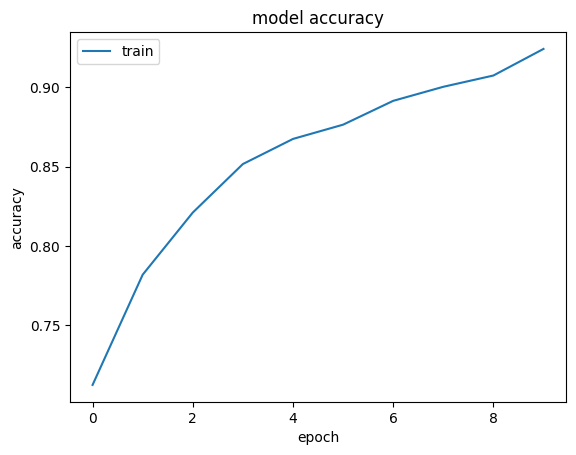

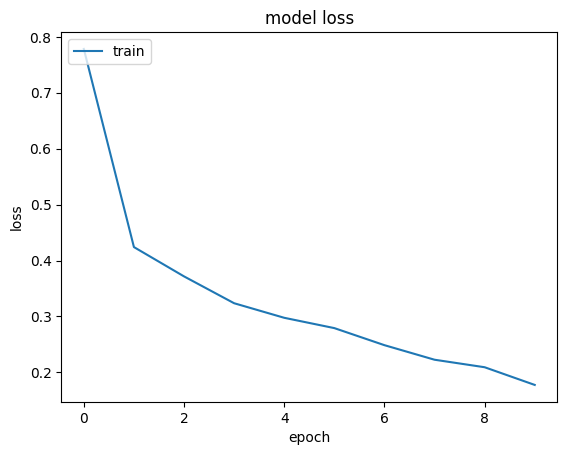

In [61]:
plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [ ]:
from scipy import signal

def butter_lowpass(cutoff, nyq_freq, order=4):
    normal_cutoff = float(cutoff) / nyq_freq
    b, a = signal.butter(order, normal_cutoff, btype='lowpass')
    return b, a

def butter_lowpass_filter(data, cutoff_freq, nyq_freq, order=4):
    # Source: https://github.com/guillaume-chevalier/filtering-stft-and-laplace-transform
    b, a = butter_lowpass(cutoff_freq, nyq_freq, order=order)
    y = signal.filtfilt(b, a, data)
    return y

def downsample_file( amplitudes, original_sr, new_sample_rate):
    return librosa.resample(y=amplitudes,
                            orig_sr=original_sr,
                            target_sr=new_sample_rate,
                            res_type='kaiser_fast'), new_sample_rate

The function below will predict on the audio data in a sliding window manner. This assumes a 4 second input window! It also assumes that the spectrograms will be of a certain shape.

In [ ]:
import math
def predict_on_entire_file(audio, sample_rate, lowpass_cutoff,
                           downsample_rate, nyquist_rate):

    # Apply a low pass fitler to get rid of high frequency components
    filtered = butter_lowpass_filter(audio, lowpass_cutoff, nyquist_rate)

    # Downsample the audio
    amplitudes, sample_rate = downsample_file(filtered, sample_rate, downsample_rate)

    # Duration of file
    file_duration = len(amplitudes)/sample_rate

    # Number of segments
    segments = math.floor(file_duration) - 4 # (-2 because our input is 2 seconds)

    # Store predictions in this list
    predictions = []

    # Loop over the file and work in small "segments"
    for position in range (0, segments):

        # Determine start of segment
        start_position = position

        # Determine end of segment
        # TO DO: make sure you enter the correct duration here based on the above
        end_position = start_position + 4

        print('start position:', start_position)
        print('end position:', end_position)

        # Extract a 4 second segment from the audio file
        audio_segment = amplitudes[start_position*downsample_rate:end_position*downsample_rate]

        print(len(audio_segment))

        # Create the spectrogram
        S = audio_to_spectrogram(audio_segment)

        print(S.shape)

        # Input spectrogram into model
        # TO DO: make sure you enter the correct shape here
        softmax = model.predict(np.reshape(S, (1,513, 76, 1)))

        print ('model output:', softmax)

        # Binary output
        binary_prediction = np.argmax(softmax,-1)

        print ('binary output:', binary_prediction[0])

        # Append result
        predictions.append('absence' if np.argmax(softmax,-1)[0]== 0 else 'presence')

        print()

    return predictions

### Test case 1

Apply your model to the first testing file, `check1.wav`. This will take some time.

In [ ]:
testfile_1, sr_1 = librosa.load('./Test_files/check1.wav')
predictions = predict_on_entire_file(testfile_1, sr_1, lowpass_cutoff,
                           downsample_rate, nyquist_rate)

# Does check1.wav have gibbon calls? You'll ahve to verify using SonicVisualiser
# Hint the answer is no.

start position: 0
end position: 4
19200
(513, 76)
1/1 [==============================] - 0s 49ms/step
model output: [[9.997178e-01 2.822447e-04]]
binary output: 0

start position: 1
end position: 5
19200
(513, 76)
1/1 [==============================] - 0s 28ms/step
model output: [[0.996687   0.00331296]]
binary output: 0

start position: 2
end position: 6
19200
(513, 76)
1/1 [==============================] - 0s 35ms/step
model output: [[0.99663585 0.00336422]]
binary output: 0

start position: 3
end position: 7
19200
(513, 76)
1/1 [==============================] - 0s 31ms/step
model output: [[0.97961116 0.02038887]]
binary output: 0

start position: 4
end position: 8
19200
(513, 76)
1/1 [==============================] - 0s 30ms/step
model output: [[9.9998379e-01 1.6227707e-05]]
binary output: 0

start position: 5
end position: 9
19200
(513, 76)
1/1 [==============================] - 0s 35ms/step
model output: [[9.9998426e-01 1.5751271e-05]]
binary output: 0

start position: 6
end po

### Task 10: Check the model predictions.

For check1.wav, there should be no gibbon predictions! So the array shold be empty.

The code below gathers all the predictions for the presence class. So if it finds any presence events from the predictions, then these will be displayed.

In [ ]:
import pandas as pd
df_predictions = pd.DataFrame(predictions, columns=['BinaryPrediction'])
prediction_indices = df_predictions[df_predictions['BinaryPrediction'] == 'presence'].index.values
prediction_indices

array([], dtype=int64)

### Test case 2

In [ ]:
testfile_2, sr_2 = librosa.load('./Test_files/check2.wav')
predictions = predict_on_entire_file(testfile_2, sr_2, lowpass_cutoff,
                           downsample_rate, nyquist_rate)

start position: 0
end position: 4
19200
(513, 76)
1/1 [==============================] - 0s 25ms/step
model output: [[0.00272143 0.99727863]]
binary output: 1

start position: 1
end position: 5
19200
(513, 76)
1/1 [==============================] - 0s 24ms/step
model output: [[1.6941108e-04 9.9983060e-01]]
binary output: 1

start position: 2
end position: 6
19200
(513, 76)
1/1 [==============================] - 0s 24ms/step
model output: [[8.954697e-05 9.999105e-01]]
binary output: 1

start position: 3
end position: 7
19200
(513, 76)
1/1 [==============================] - 0s 25ms/step
model output: [[2.6102472e-05 9.9997389e-01]]
binary output: 1

start position: 4
end position: 8
19200
(513, 76)
1/1 [==============================] - 0s 24ms/step
model output: [[4.6482078e-06 9.9999535e-01]]
binary output: 1

start position: 5
end position: 9
19200
(513, 76)
1/1 [==============================] - 0s 24ms/step
model output: [[3.779135e-05 9.999622e-01]]
binary output: 1

start position

### Task 11: Check the model predictions.

Did your model predict gibbon calls?

If you open the file in Sonic Visualiser, did your model predict, roughly, the correct vocalisation times?

In [ ]:
import pandas as pd
df_predictions = pd.DataFrame(predictions, columns=['BinaryPrediction'])
prediction_indices = df_predictions[df_predictions['BinaryPrediction'] == 'presence'].index.values
prediction_indices

array([20, 21, 22, 23, 24, 25, 26, 41, 42, 43, 44, 45, 46, 47, 48])

### Task 12: Test case 3

For the next test cases, repeat the steps above for the different files.

In [ ]:
# TO DO
testfile_3, sr_3 = librosa.load('./Test_files/check3.wav')
predictions = predict_on_entire_file(testfile_3, sr_3, lowpass_cutoff,
                           downsample_rate, nyquist_rate)

start position: 0
end position: 4
19200
(513, 76)
1/1 [==============================] - 0s 27ms/step
model output: [[0.99802965 0.00197031]]
binary output: 0

start position: 1
end position: 5
19200
(513, 76)
1/1 [==============================] - 0s 30ms/step
model output: [[0.99414957 0.00585041]]
binary output: 0

start position: 2
end position: 6
19200
(513, 76)
1/1 [==============================] - 0s 28ms/step
model output: [[0.99213326 0.00786668]]
binary output: 0

start position: 3
end position: 7
19200
(513, 76)
1/1 [==============================] - 0s 28ms/step
model output: [[0.9905257  0.00947426]]
binary output: 0

start position: 4
end position: 8
19200
(513, 76)
1/1 [==============================] - 0s 27ms/step
model output: [[0.9941453  0.00585474]]
binary output: 0

start position: 5
end position: 9
19200
(513, 76)
1/1 [==============================] - 0s 30ms/step
model output: [[9.9929810e-01 7.0183654e-04]]
binary output: 0

start position: 6
end position: 10

In [ ]:
import pandas as pd
df_predictions = pd.DataFrame(predictions, columns=['BinaryPrediction'])
prediction_indices = df_predictions[df_predictions['BinaryPrediction'] == 'presence'].index.values
prediction_indices

array([], dtype=int64)

### Task 13: Test case 4

In [ ]:
# TO DO
testfile_4, sr_4 = librosa.load('./Test_files/check4.wav')
predictions = predict_on_entire_file(testfile_4, sr_4, lowpass_cutoff,
                           downsample_rate, nyquist_rate)

start position: 0
end position: 4
19200
(513, 76)
1/1 [==============================] - 0s 30ms/step
model output: [[0.8647469  0.13525306]]
binary output: 0

start position: 1
end position: 5
19200
(513, 76)
1/1 [==============================] - 0s 31ms/step
model output: [[0.83754575 0.16245423]]
binary output: 0

start position: 2
end position: 6
19200
(513, 76)
1/1 [==============================] - 0s 33ms/step
model output: [[0.8370226 0.1629774]]
binary output: 0

start position: 3
end position: 7
19200
(513, 76)
1/1 [==============================] - 0s 30ms/step
model output: [[0.80354756 0.19645244]]
binary output: 0

start position: 4
end position: 8
19200
(513, 76)
1/1 [==============================] - 0s 31ms/step
model output: [[0.742213   0.25778696]]
binary output: 0

start position: 5
end position: 9
19200
(513, 76)
1/1 [==============================] - 0s 33ms/step
model output: [[0.91767824 0.08232171]]
binary output: 0

start position: 6
end position: 10
19200
(

In [ ]:
import pandas as pd
df_predictions = pd.DataFrame(predictions, columns=['BinaryPrediction'])
prediction_indices = df_predictions[df_predictions['BinaryPrediction'] == 'presence'].index.values
prediction_indices

array([ 8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 33, 34, 66, 68, 78])

### Task 14: Test case 5

In [ ]:
# TO DO
testfile_5, sr_5 = librosa.load('./Test_files/check2.wav')
predictions = predict_on_entire_file(testfile_5, sr_5, lowpass_cutoff,
                           downsample_rate, nyquist_rate)

start position: 0
end position: 4
19200
(513, 76)
1/1 [==============================] - 0s 31ms/step
model output: [[0.00272143 0.99727863]]
binary output: 1

start position: 1
end position: 5
19200
(513, 76)
1/1 [==============================] - 0s 37ms/step
model output: [[1.6941108e-04 9.9983060e-01]]
binary output: 1

start position: 2
end position: 6
19200
(513, 76)
1/1 [==============================] - 0s 30ms/step
model output: [[8.954697e-05 9.999105e-01]]
binary output: 1

start position: 3
end position: 7
19200
(513, 76)
1/1 [==============================] - 0s 35ms/step
model output: [[2.6102472e-05 9.9997389e-01]]
binary output: 1

start position: 4
end position: 8
19200
(513, 76)
1/1 [==============================] - 0s 39ms/step
model output: [[4.6482078e-06 9.9999535e-01]]
binary output: 1

start position: 5
end position: 9
19200
(513, 76)
1/1 [==============================] - 0s 33ms/step
model output: [[3.779135e-05 9.999622e-01]]
binary output: 1

start position

In [ ]:
import pandas as pd
df_predictions = pd.DataFrame(predictions, columns=['BinaryPrediction'])
prediction_indices = df_predictions[df_predictions['BinaryPrediction'] == 'presence'].index.values
prediction_indices

array([  0,   1,   2,   3,   4,   5,   6,   7,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  42,  43,  44,  45,  46,  47,  48,  49,
        50,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  85,  86,
        87,  88,  89,  90,  91,  92,  93,  94, 106, 107, 108, 109, 110,
       111, 112, 113, 114, 115, 116, 130, 131, 132, 133, 134, 135, 136,
       137, 138, 139, 151, 152, 153, 154, 155, 156, 157])

### Task 15:  Test case 6

In [ ]:
# TO DO
testfile_6, sr_6 = librosa.load('./Test_files/check6.wav')
predictions = predict_on_entire_file(testfile_6, sr_6, lowpass_cutoff,
                           downsample_rate, nyquist_rate)

start position: 0
end position: 4
19200
(513, 76)
1/1 [==============================] - 0s 25ms/step
model output: [[0.17766133 0.8223387 ]]
binary output: 1

start position: 1
end position: 5
19200
(513, 76)
1/1 [==============================] - 0s 30ms/step
model output: [[0.24125916 0.7587409 ]]
binary output: 1

start position: 2
end position: 6
19200
(513, 76)
1/1 [==============================] - 0s 32ms/step
model output: [[0.61668795 0.38331196]]
binary output: 0

start position: 3
end position: 7
19200
(513, 76)
1/1 [==============================] - 0s 27ms/step
model output: [[0.8788816 0.1211184]]
binary output: 0

start position: 4
end position: 8
19200
(513, 76)
1/1 [==============================] - 0s 25ms/step
model output: [[0.9648246  0.03517537]]
binary output: 0

start position: 5
end position: 9
19200
(513, 76)
1/1 [==============================] - 0s 26ms/step
model output: [[0.9313918  0.06860828]]
binary output: 0

start position: 6
end position: 10
19200
(

In [ ]:
import pandas as pd
df_predictions = pd.DataFrame(predictions, columns=['BinaryPrediction'])
prediction_indices = df_predictions[df_predictions['BinaryPrediction'] == 'presence'].index.values
prediction_indices

array([ 0,  1,  6,  9, 43, 44, 45, 46])

### Task 16: Test case 7

In [ ]:
# TO DO
testfile_7, sr_7 = librosa.load('./Test_files/check7.wav')
predictions = predict_on_entire_file(testfile_7, sr_7, lowpass_cutoff,
                           downsample_rate, nyquist_rate)

start position: 0
end position: 4
19200
(513, 76)
1/1 [==============================] - 0s 27ms/step
model output: [[0.02649076 0.9735092 ]]
binary output: 1

start position: 1
end position: 5
19200
(513, 76)
1/1 [==============================] - 0s 25ms/step
model output: [[0.0066134  0.99338657]]
binary output: 1

start position: 2
end position: 6
19200
(513, 76)
1/1 [==============================] - 0s 26ms/step
model output: [[0.00183526 0.9981647 ]]
binary output: 1

start position: 3
end position: 7
19200
(513, 76)
1/1 [==============================] - 0s 24ms/step
model output: [[5.4555788e-04 9.9945444e-01]]
binary output: 1

start position: 4
end position: 8
19200
(513, 76)
1/1 [==============================] - 0s 25ms/step
model output: [[3.4899029e-04 9.9965096e-01]]
binary output: 1

start position: 5
end position: 9
19200
(513, 76)
1/1 [==============================] - 0s 26ms/step
model output: [[0.00288017 0.9971199 ]]
binary output: 1

start position: 6
end positi

In [ ]:
import pandas as pd
df_predictions = pd.DataFrame(predictions, columns=['BinaryPrediction'])
prediction_indices = df_predictions[df_predictions['BinaryPrediction'] == 'presence'].index.values
prediction_indices

array([  0,   1,   2,   3,   4,   5,   6,   7,  17,  18,  19,  20,  21,
        22,  23,  24,  35,  36,  37,  38,  39,  40,  41,  42,  56,  57,
        58,  59,  60,  61,  62,  69,  70,  71,  72,  73,  74,  75,  88,
        89,  90,  91,  92,  93,  94,  95,  96, 106, 107, 108, 109, 110,
       111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 139, 140,
       141, 142, 143, 144, 145, 146, 147, 165, 166, 167, 168, 169, 170,
       171, 186, 187, 188, 189, 190, 191, 192, 193, 203, 204, 205, 206,
       207, 208, 209, 210, 211, 212, 213, 214, 217, 225, 226, 227, 228,
       229, 230, 231, 232, 233, 234, 235, 242, 243, 244, 257, 258, 259,
       260, 261, 262, 263, 264, 265, 272, 273, 277, 278, 279, 280, 281,
       282, 283, 284, 285, 293, 294, 296, 297, 298, 299, 300, 301, 302,
       303, 304, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322,
       323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 349, 350,
       351, 352, 353, 354, 355, 356, 357, 358, 359, 378, 379, 38

### Task 17:  Test case 8

In [ ]:
# TO DO
testfile_8, sr_8 = librosa.load('./Test_files/check8.wav')
predictions = predict_on_entire_file(testfile_8, sr_8, lowpass_cutoff,
                           downsample_rate, nyquist_rate)

start position: 0
end position: 4
19200
(513, 76)
1/1 [==============================] - 0s 28ms/step
model output: [[0.99843365 0.0015663 ]]
binary output: 0

start position: 1
end position: 5
19200
(513, 76)
1/1 [==============================] - 0s 27ms/step
model output: [[9.9995244e-01 4.7553774e-05]]
binary output: 0

start position: 2
end position: 6
19200
(513, 76)
1/1 [==============================] - 0s 36ms/step
model output: [[9.9998105e-01 1.9011217e-05]]
binary output: 0

start position: 3
end position: 7
19200
(513, 76)
1/1 [==============================] - 0s 31ms/step
model output: [[9.9997556e-01 2.4444951e-05]]
binary output: 0

start position: 4
end position: 8
19200
(513, 76)
1/1 [==============================] - 0s 31ms/step
model output: [[0.99690515 0.0030948 ]]
binary output: 0

start position: 5
end position: 9
19200
(513, 76)
1/1 [==============================] - 0s 34ms/step
model output: [[9.9902785e-01 9.7214791e-04]]
binary output: 0

start position: 

In [ ]:
import pandas as pd
df_predictions = pd.DataFrame(predictions, columns=['BinaryPrediction'])
prediction_indices = df_predictions[df_predictions['BinaryPrediction'] == 'presence'].index.values
prediction_indices

array([23, 24, 25, 26, 27, 28, 29, 43, 44, 45, 46, 47, 48, 49, 60, 61, 62,
       63, 64, 65, 75, 76, 77, 78, 79, 80, 81, 82, 86, 88, 94, 95, 96, 97])

### Task 18:  Test case 9

In [ ]:
# TO DO
testfile_9, sr_9 = librosa.load('./Test_files/check9.wav')
predictions = predict_on_entire_file(testfile_9, sr_9, lowpass_cutoff,
                           downsample_rate, nyquist_rate)

start position: 0
end position: 4
19200
(513, 76)
1/1 [==============================] - 0s 29ms/step
model output: [[0.00106099 0.998939  ]]
binary output: 1

start position: 1
end position: 5
19200
(513, 76)
1/1 [==============================] - 0s 27ms/step
model output: [[2.9548910e-04 9.9970454e-01]]
binary output: 1

start position: 2
end position: 6
19200
(513, 76)
1/1 [==============================] - 0s 30ms/step
model output: [[1.2525865e-04 9.9987471e-01]]
binary output: 1

start position: 3
end position: 7
19200
(513, 76)
1/1 [==============================] - 0s 31ms/step
model output: [[2.1131318e-04 9.9978870e-01]]
binary output: 1

start position: 4
end position: 8
19200
(513, 76)
1/1 [==============================] - 0s 28ms/step
model output: [[6.7437784e-04 9.9932563e-01]]
binary output: 1

start position: 5
end position: 9
19200
(513, 76)
1/1 [==============================] - 0s 38ms/step
model output: [[0.51363176 0.4863682 ]]
binary output: 0

start position: 

In [ ]:
import pandas as pd
df_predictions = pd.DataFrame(predictions, columns=['BinaryPrediction'])
prediction_indices = df_predictions[df_predictions['BinaryPrediction'] == 'presence'].index.values
prediction_indices

array([ 0,  1,  2,  3,  4,  6, 16, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27,
       34, 36, 39, 40, 41, 42, 43, 44, 45, 46, 51, 52, 53, 54, 56, 57, 58,
       59, 60])

### Task 19: Test case 10

In [ ]:
# TO DO
testfile_10, sr_10 = librosa.load('./Test_files/check10.wav')
predictions = predict_on_entire_file(testfile_10, sr_10, lowpass_cutoff,
                           downsample_rate, nyquist_rate)

start position: 0
end position: 4
19200
(513, 76)
1/1 [==============================] - 0s 41ms/step
model output: [[9.998084e-01 1.916883e-04]]
binary output: 0

start position: 1
end position: 5
19200
(513, 76)
1/1 [==============================] - 0s 42ms/step
model output: [[9.997011e-01 2.989273e-04]]
binary output: 0

start position: 2
end position: 6
19200
(513, 76)
1/1 [==============================] - 0s 34ms/step
model output: [[9.9993086e-01 6.9109112e-05]]
binary output: 0

start position: 3
end position: 7
19200
(513, 76)
1/1 [==============================] - 0s 41ms/step
model output: [[9.999336e-01 6.645296e-05]]
binary output: 0

start position: 4
end position: 8
19200
(513, 76)
1/1 [==============================] - 0s 40ms/step
model output: [[9.9997532e-01 2.4729181e-05]]
binary output: 0

start position: 5
end position: 9
19200
(513, 76)
1/1 [==============================] - 0s 44ms/step
model output: [[9.9997604e-01 2.3906814e-05]]
binary output: 0

start posi

In [ ]:
import pandas as pd
df_predictions = pd.DataFrame(predictions, columns=['BinaryPrediction'])
prediction_indices = df_predictions[df_predictions['BinaryPrediction'] == 'presence'].index.values
prediction_indices

array([20, 21, 22, 23, 24, 25, 26, 41, 42, 43, 44, 45, 46, 47, 48])